## Sentiment Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

plt.style.use('ggplot')

import nltk

In [3]:
df = pd.read_csv('Reviews.csv')

df = df.head(500)
print(df.shape)

(500, 10)


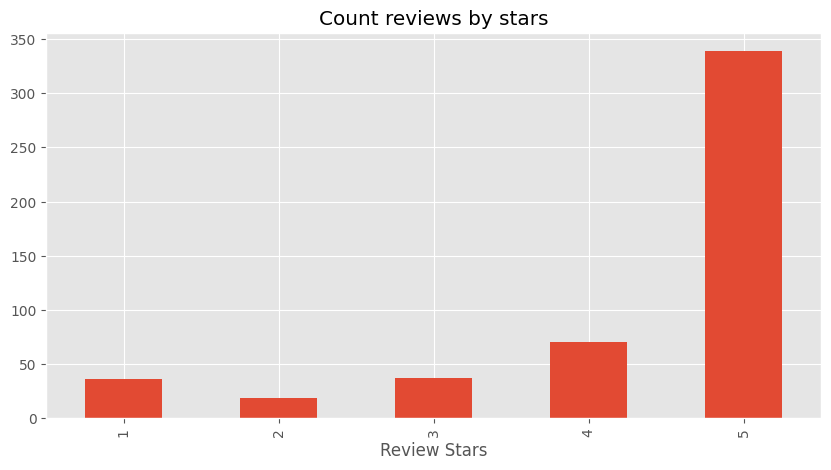

In [4]:
ax = df['Score'].value_counts().sort_index().plot(kind="bar", 
                                             title="Count reviews by stars", 
                                             figsize=(10,5))
ax.set_xlabel('Review Stars')
plt.show()

### VEDAR APPROACH


In [5]:

from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


sia = SentimentIntensityAnalyzer()
# sia = SentimentIntensityAnalyzer()

In [6]:
sia.polarity_scores('I am happy')

{'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}

In [7]:
# Run on whole dataset

result = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    result[myid] = sia.polarity_scores(text)
    

  0%|          | 0/500 [00:00<?, ?it/s]

In [8]:
vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how="left")

In [9]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Plot Vader results

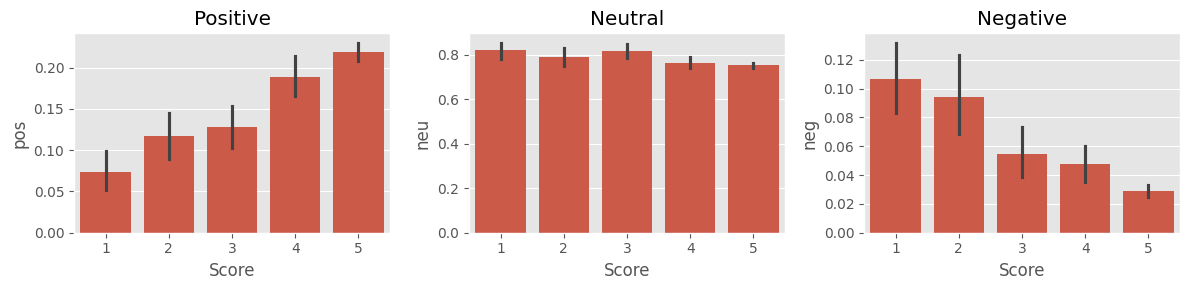

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12,3))
sb.barplot(data=vaders, x="Score", y="pos", ax=axs[0])
sb.barplot(data=vaders, x="Score", y="neu", ax=axs[1])
sb.barplot(data=vaders, x="Score", y="neg", ax=axs[2])
axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

### Roberta Pretained Model

In [11]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax



In [12]:
MODEL = f'cardiffnlp/twitter-roberta-base-sentiment'
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [13]:
example = "This oatmeal is not good. Its mushy, soft, I dont like it. Quaker Oats is the way to go."
encoded_text = tokenizer(example, return_tensors="pt")
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
scores_dict

{'roberta_neg': 0.9755052,
 'roberta_neu': 0.021397218,
 'roberta_pos': 0.0030976264}

In [14]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors="pt")
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict



In [15]:
result = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_re = {}
        for key, value in vader_result.items():
            vader_result_re[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_re, **roberta_result}
        result[myid] = both
    except RuntimeError:
        print(f"Broke for id {myid}")
        


  0%|          | 0/500 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187


In [20]:
results_df = pd.DataFrame(result).T
results_df = results_df.reset_index().rename(columns={'index':'Id'})
results_df = results_df.merge(df, how='left')
results_df


,Id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,0.009624,0.049980,0.940395,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,0.508986,0.452414,0.038600,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,0.003229,0.098067,0.898704,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,0.002295,0.090219,0.907486,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,0.001635,0.010302,0.988063,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,496,0.000,0.554,0.446,0.9725,0.001906,0.009862,0.988232,B000G6RYNE,APGAA43E3WPN7,Darren,0,0,5,1201392000,amazing chips,i rarely eat chips but i saw these and tried t...
494,497,0.059,0.799,0.142,0.7833,0.004415,0.034215,0.961369,B000G6RYNE,ABR7HU5H1KNE,Keith,0,0,5,1196726400,Best Chip Ever,This is easily the best potato chip that I hav...
495,498,0.025,0.762,0.212,0.9848,0.006427,0.074537,0.919036,B000G6RYNE,AJQD2WWJYOYFQ,bubbles,0,0,4,1186617600,"Tangy, spicy, and sweet- oh my!",Kettle Chips Spicy Thai potato chips have the ...
496,499,0.041,0.904,0.055,0.1280,0.865614,0.119366,0.015020,B000G6RYNE,A16YH487W9ZYO0,Bruce G. Lindsay,0,0,4,1184198400,An indulgence with a bite,"Okay, I should not eat potato chips, nor shoul..."
